In [1]:
import requests
import os
import numpy as np
import numpy.linalg as linalg
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.io as io
import TIMBRE.helpers as helpers
import TIMBRE.get_data

In [2]:
from keras.callbacks import EarlyStopping
from keras import models, layers, optimizers, backend, constraints, activations
import complexnn
from keras import utils as np_utils

#redefine TIMBRE function with legacy Adam optimizer so it will run on Mac

def TIMBRE(X, Y, inds_test, inds_train, hidden_nodes=0, learn_rate=.001, is_categorical=True, verbosity=0, save_path=None, filename=None):
    """
    Learns oscillatory patterns that are predictive of class labels

    Parameters:
    - X = Multi-channel data (T samples x N channels, complex-valued)
    - Y = Category labels (T samples, integer-valued)
    - inds_test = test indices (Either T x 1 boolean, or U x 1 integers)
    - inds_train = train indices (Either T x 1 boolean, or U x 1 integers)
    - hidden_nodes = how many nodes to use (no hidden layer if set to 0)
    - learn_rate = how quickly the network learns
    - is_categorical = whether the output consists of discrete classes
    - verbosity = amount of model training info to output (default = 0)

    Returns:
    - model: trained network
    - fittedModel: history of loss and accuracy for test and train data
    - test_acc: accuracy on test data after training
    """

    # stack the real and imaginary components of the data
    X = np.concatenate((np.real(X), np.imag(X)), axis=1)
    # use one-hot encoding for the class labels
    if is_categorical:
        Y = np_utils.to_categorical(Y)
        my_loss = 'categorical_crossentropy'
    else:
        my_loss = 'kde'
    backend.clear_session()
    # Early Stopping: stop training model when test loss stops decreasing
    es = EarlyStopping(monitor='val_loss', patience=1)
    # Specify the algorithm and step size used by gradient descent
    adam = optimizers.legacy.Adam(learning_rate=learn_rate)
    if hidden_nodes > 0:
        num_chans = hidden_nodes
    else:
        num_chans = Y.shape[1]
    model = models.Sequential()
    # Layer 1: Takes a complex-valued projection of the input
    model.add(complexnn.dense.ComplexDense(num_chans, input_shape=(X.shape[1],), use_bias=False,
                                           kernel_constraint=constraints.unit_norm()))
    # Layer 2: Converts complex-valued output of layer 0 to a real-valued magnitude
    model.add(layers.Lambda(lambda x: (x[:, :x.shape[1] // 2] ** 2 + x[:, x.shape[1] // 2:] ** 2) ** .5))
    # Layer 3: Softmax of layer 2
    model.add(layers.Activation(activations.softmax))
    if hidden_nodes > 0:  # Need another layer for output
        model.add(layers.Dense(Y.shape[1], activation='softmax'))
    model.compile(loss=my_loss, optimizer=adam, metrics=['accuracy'])
    # Train the model
    fittedModel = model.fit(X[inds_train, :], Y[inds_train, :], epochs=100,
                            verbose=0, validation_data=(X[inds_test, :], Y[inds_test, :]),
                            shuffle=True, callbacks=[es])
    test_acc = fittedModel.history['val_accuracy'][-1]
    
    #Save trained model (addition from original TIMBRE function)
    if filename:
        from keras.models import save_model
        save_model(model, filename + ".h5")
        
    return model, fittedModel, test_acc

In [3]:
def filter(matrix, range_low, range_high, btype='bp', fs = 1250/8, order = 3, use_hilbert = True):
    #Bandpass filter for specific broadbands 
    #TIMBRE filter function will not work for bandpass filters!
    nyq = 0.5*fs
    normal_range_low = range_low / nyq
    normal_range_high = range_high / nyq
    b, a = signal.butter(order, [normal_range_low, normal_range_high], btype=btype, analog=False)
    filt_X = signal.filtfilt(b, a, matrix, axis=0)
    return filt_X 

In [4]:
def band_whiten(X, inds_train, u, Xv):
    #function to whiten signals using the variance of another signal 
    #rather than individually calculating variance for each signal
    X = X @ np.conj(u.T)
    X = X / Xv
    return X

In [5]:
data = io.loadmat('data03.mat') #load drudged data to train models, using session 3 as session 1 is too big 
lapID = data['lapID']

full_LFPs = helpers.filter_data(data['lfps'], 2, fs=1250/8, use_hilbert=True)
theta_preHilbert = filter(data['lfps'], range_low = 6, range_high = 12, btype= 'bp',order= 2) 
harm_preHilbert = filter(data['lfps'], range_low = 14, range_high = 20, btype= 'bp',order= 2)

theta_LFPs = signal.hilbert(theta_preHilbert, axis= 0)
harm_LFPs = signal.hilbert(harm_preHilbert, axis= 0)
double_LFPs = np.abs(theta_LFPs)*np.exp(np.angle(theta_LFPs)*2*1j)

In [6]:
#Split data into train and test sections
inds_test, inds_train = helpers.test_train(lapID, 1, n_folds=5, which_fold=0)

In [7]:
#Whiten signals
w_theta, u, Xv = helpers.whiten(theta_LFPs, inds_train)
w_harm = band_whiten(harm_LFPs, inds_train, u, Xv)
w_double = band_whiten(double_LFPs, inds_train, u, Xv)

In [8]:
#Train TIMBRE on each of the signals
theta_model, theta_fittedModel, theta_test_acc = TIMBRE(w_theta, lapID[:,1], inds_test, inds_train, hidden_nodes=48, save_path="", filename="theta_model")
harm_model, harm_fittedModel, harm_test_acc = TIMBRE(w_harm, lapID[:,1], inds_test, inds_train, hidden_nodes=48, save_path="", filename="harm_model")
double_model, double_fittedModel, double_test_acc = TIMBRE(w_double, lapID[:,1], inds_test, inds_train, hidden_nodes=48, save_path="", filename="double_model")

/var/folders/9p/9b3pkj717gzd6mtq0_87y1ww0000gn/T/ipykernel_52344/2791076190.py:65: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, filename + ".h5")


In [9]:
#Concatenate data for testing
test_theta = np.concatenate((np.real(w_theta), np.imag(w_theta)), axis=1)
test_harm = np.concatenate((np.real(w_harm), np.imag(w_harm)), axis=1)
test_double = np.concatenate((np.real(w_double), np.imag(w_double)), axis=1)

test_Y = np_utils.to_categorical(lapID[:, 1]) #one-hot encode LapID for testing

In [10]:
#Evaluate accuracies for each train/test combo
trained = ['theta', "harmonic", 'doubled']
tested = ['theta', "harmonic", 'doubled']

all_scores = np.zeros((3, 3))

trained_models = [theta_model, harm_model, double_model, ]
test_data = [test_theta, test_harm, test_double]

for i in range(len(trained)):
    for j in range(len(tested)):
        all_scores[i, j] = trained_models[i].evaluate(test_data[j][inds_test, :], test_Y[inds_test, :])[1]
        
print(all_scores)

165/165 [==============================] - 0s 356us/step - loss: 0.2582 - accuracy: 0.9278
[[0.92190474 0.63809526 0.65200001]
 [0.51523811 0.84971428 0.31257144]
 [0.46838096 0.26914287 0.92780954]]


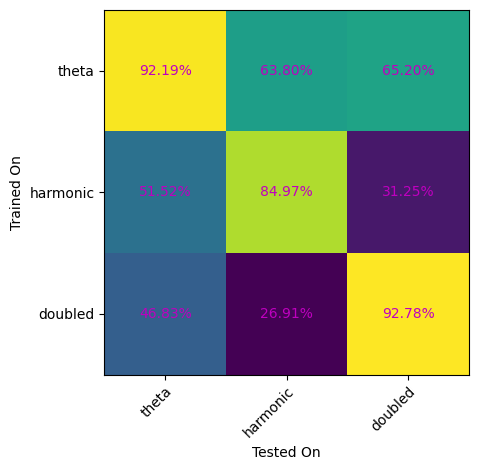

In [11]:
# Display accuracies

fig, ax = plt.subplots()
im = ax.imshow(all_scores)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(tested)), labels=tested)
ax.set_yticks(np.arange(len(trained)), labels=trained)
ax.set_xlabel('Tested On')
ax.set_ylabel('Trained On')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(trained)):
    for j in range(len(tested)):
        text = ax.text(j, i, str(all_scores[i, j]*100)[:5]+'%',
                       ha="center", va="center", color="m")

ax.set_title("")
fig.tight_layout()
plt.show()

In [12]:
#Isolate phase information
theta_phases = np.exp(1j*np.angle(theta_LFPs))
harm_phases = np.exp(1j*np.angle(harm_LFPs))
double_phases = np.exp(1j*np.angle(theta_LFPs)*2)

In [13]:
#Whiten phase-only signals
w_theta_phase, u, Xv = helpers.whiten(theta_phases, inds_train)
w_harm_phase = band_whiten(harm_phases, inds_train, u, Xv)
w_double_phase = band_whiten(double_phases, inds_train, u, Xv)

In [14]:
#Train TIMBRE on each of the phase only signals
theta_phase_model, theta_fittedModel, theta_phase_test_acc = TIMBRE(w_theta_phase, lapID[:,1], inds_test, inds_train, hidden_nodes=48, save_path="", filename="theta_phase_model")
harm_phase_model, harm_phase_fittedModel, harm_phase_test_acc = TIMBRE(w_harm_phase, lapID[:,1], inds_test, inds_train, hidden_nodes=48, save_path="", filename="harm_phase_model")
double_phase_model, double_phase_fittedModel, double_phase_test_acc = TIMBRE(w_double_phase, lapID[:,1], inds_test, inds_train, hidden_nodes=48, save_path="", filename="double_phase_model")

/var/folders/9p/9b3pkj717gzd6mtq0_87y1ww0000gn/T/ipykernel_52344/2791076190.py:65: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, filename + ".h5")


In [15]:
#Concatenate phase-only data for testing
test_theta_phase = np.concatenate((np.real(w_theta_phase), np.imag(w_theta_phase)), axis=1)
test_harm_phase = np.concatenate((np.real(w_harm_phase), np.imag(w_harm_phase)), axis=1)
test_double_phase = np.concatenate((np.real(w_double_phase), np.imag(w_double_phase)), axis=1)

In [16]:
#Evaluate accuracies for each train/test combo
trained_phase = ['theta phases', "harmonic phases", 'doubled phases']
tested_phase = ['theta phases', "harmonic phases", 'doubled phases']

all_scores_phase = np.zeros((3, 3))

trained_phase_models = [theta_phase_model, harm_phase_model, double_phase_model, ]
test_data_phase = [test_theta_phase, test_harm_phase, test_double_phase]

for i in range(len(trained)):
    for j in range(len(tested)):
        all_scores_phase[i, j] = trained_phase_models[i].evaluate(test_data_phase[j][inds_test, :], test_Y[inds_test, :])[1]
        
print(all_scores_phase)

165/165 [==============================] - 0s 780us/step - loss: 0.2707 - accuracy: 0.9137
[[0.9289524  0.54533333 0.89885712]
 [0.48019049 0.75447619 0.49828571]
 [0.68857145 0.40114287 0.91371429]]


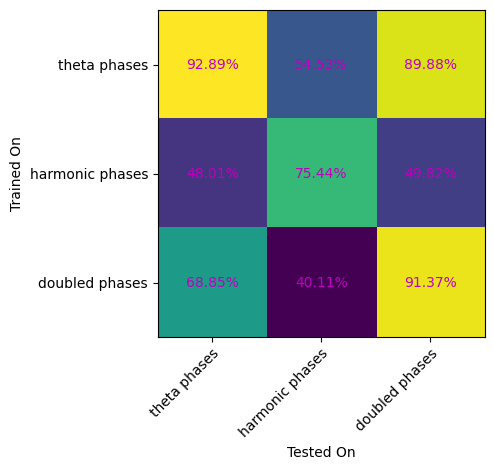

In [17]:
# Display accuracies for phase-only models

fig, ax = plt.subplots()
im = ax.imshow(all_scores_phase)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(tested_phase)), labels=tested_phase)
ax.set_yticks(np.arange(len(trained_phase)), labels=trained_phase)
ax.set_xlabel('Tested On')
ax.set_ylabel('Trained On')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(trained_phase)):
    for j in range(len(tested_phase)):
        text = ax.text(j, i, str(all_scores_phase[i, j]*100)[:5]+'%',
                       ha="center", va="center", color="m")

ax.set_title("")
fig.tight_layout()
plt.show()